In [1]:
import pandas as pd
from functools import reduce
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.patches as mpatches

# File imports
## Adjen.. Matrix processing

In [2]:
adj_mat = pd.read_csv('../Griffin_data/Adjacency_Matrix_Output_Currency.csv', index_col='Unnamed: 0') #, index_col='Unnamed: 0'
adj_mat = adj_mat[['src', 'dst', 'date', 'cluster_src', 'neighbours', 'neighbours_cluster', 
                   'neighbours_!cluster', 'cluster_dst', 'twitter_query']]

adj_mat_ETH2 = adj_mat.loc[adj_mat['twitter_query'] == 'ETH2']
adj_mat_SHIB = adj_mat.loc[adj_mat['twitter_query'] == 'SHIB']
adj_mat_SOL = adj_mat.loc[adj_mat['twitter_query'] == 'SOL']
adj_mat_ETH = adj_mat.loc[adj_mat['twitter_query'] == 'ETH']
adj_mat_LINK = adj_mat.loc[adj_mat['twitter_query'] == 'LINK']
adj_mat_BTC = adj_mat.loc[adj_mat['twitter_query'] == 'BTC']
adj_mat_DOGE = adj_mat.loc[adj_mat['twitter_query'] == 'DOGE']

## News dataframe processing

In [3]:
news_df = pd.read_excel('../GPT-3_Approach/output_data_sentiment.xlsx', index_col='Unnamed: 0').drop(columns=['Unnamed: 0.1','Unnamed: 0.1.1'])

news_df['Query'] = news_df['Query'].str.replace('bitcoin', 'BTC')
news_df['Query'] = news_df['Query'].str.replace('ethereum2', 'ETH2')
news_df['Query'] = news_df['Query'].str.replace('shibainucoin', 'SHIB')
news_df['Query'] = news_df['Query'].str.replace('solana', 'SOL')
news_df['Query'] = news_df['Query'].str.replace('ethereum', 'ETH')
news_df['Query'] = news_df['Query'].str.replace('Chainlink', 'LINK')
news_df['Query'] = news_df['Query'].str.replace('dogecoin', 'DOGE')

news_df_BTC = news_df.loc[news_df['Query'] == 'BTC']
news_df_ETH2 = news_df.loc[news_df['Query'] == 'ETH2']
news_df_SHIB = news_df.loc[news_df['Query'] == 'SHIB']
news_df_SOL = news_df.loc[news_df['Query'] == 'SOL']
news_df_ETH = news_df.loc[news_df['Query'] == 'ETH']
news_df_LINK = news_df.loc[news_df['Query'] == 'LINK']
news_df_DOGE = news_df.loc[news_df['Query'] == 'DOGE']

## Crypto data import

In [4]:
df_ta_BTC = pd.read_csv('ta_df/df_ta_BTC.csv')
df_ta_SHIB = pd.read_csv('ta_df/df_ta_SHIB.csv')
df_ta_SOL = pd.read_csv('ta_df/df_ta_SOL.csv')
df_ta_ETH = pd.read_csv('ta_df/df_ta_ETH.csv')
df_ta_LINK = pd.read_csv('ta_df/df_ta_LINK.csv')
df_ta_DOGE = pd.read_csv('ta_df/df_ta_DOGE.csv')
df_ta_SHIB = pd.read_csv('ta_df/df_ta_SHIB.csv')

# Define Model
## Functions

In [5]:
def cluster_strength(adj_mat):
    adj_mat['cluster_strength'] = adj_mat['neighbours_cluster'] / adj_mat['neighbours']
    
    adj_mat['date'] = pd.to_datetime(adj_mat['date'])
    adj_mat_grouped = adj_mat.groupby([pd.Grouper(key='date', freq='D'),'cluster_src']).min()
    
    # cluster strength
    cs_day = adj_mat.groupby(['date'])['cluster_strength'].min()
    cs_day = cs_day.to_frame()

    return cs_day

In [6]:
def merge_dataframe(df_ta, news_df, cs_day):
    df_ta = df_ta.rename(columns={'Date':'date'})


    df_ta['date'] = pd.to_datetime(df_ta['date'])
    news_df['date'] = pd.to_datetime(news_df['date'])
    cs_day = cs_day.reset_index()
    cs_day['date'] = pd.to_datetime(cs_day['date'])
    
    merge_1 = df_ta.merge(cs_day, on='date')
    merge_2 = merge_1.merge(news_df, on='date')
    merge_2
    
    merge_2.set_index('date', inplace=True)
    merge_2 = merge_2['2021-11-05':'2021-12-26']

    merged_cols = ['Close' ,'calculated_average', 'sentiment_bin', 'cluster_strength']
    df_final = merge_2[merged_cols]

    return df_final

In [7]:
def calculate_model(df_final):
    df = df_final.reset_index().copy()

    df = df[df.sentiment_bin != 'void']
    df = df[df.cluster_strength != 'void']

    df['calculated_average'] = pd.to_numeric(df['calculated_average'])
    df['sentiment_bin'] = pd.to_numeric(df['sentiment_bin'])
    df['cluster_strength'] = pd.to_numeric(df['cluster_strength'])

    # sum of scores
    df['x'] = df['sentiment_bin'] + df['calculated_average']

    # payoffs
    df['a'] = 0

    for index, row in df.iterrows():
        df.loc[index, 'a'] = 1 / (1 + math.exp( -(df.loc[index, 'x'])))

    df['b'] = 1 - df['a']

    # threshold
    df['q'] = df['b'] / (df['a'] + df['b'])

    df['1-q'] = 1 - df['q']

    df_result = df[['date', 'a', 'cluster_strength', 'Close']].set_index('date')
    
    return df_result

In [8]:
def plot_figure(df_result, query):
    X = df_result.index.values
    y_cluster_strength = df_result['cluster_strength']
    y_a = df_result['a']
    y_close = df_result['Close']
    
    fig, ax = plt.subplots(figsize=(14, 6))
    fig.subplots_adjust(right=0.75)

    twin2 = ax.twinx()

    p1, = ax.plot(X, y_cluster_strength, label = "Cluster Strength", linewidth=1.0, color="blue")
    p2, = ax.plot(X, y_a, label = "a", linewidth=1.0, color="red")
    p3, = twin2.plot(X, y_close, '--',label = "Currency close (USD)", linewidth=0.75, color="green")
   
    ax.fill_between(X, y_a, y_cluster_strength, where=y_a > y_cluster_strength, facecolor='yellow', 
                    alpha=1, interpolate=True)
    p4 = mpatches.Patch(color='yellow', alpha=1, label='Complete cascade possible')
    
    ax.set_xlabel("Date")
    twin2.set_ylabel("Currency Close (USD)")

    ax.yaxis.label.set_color(p1.get_color())
    twin2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    #ax.tick_params(axis='x', **tkw)
    ax.xaxis.set_minor_locator(md.DayLocator(interval=1))
    ax.xaxis.set_major_locator(md.DayLocator(interval=3))
    plt.gcf().autofmt_xdate()
    ax.grid(linestyle = '--')

    ax.legend(handles=[p1, p2, p3, p4])
    ax.set_title(query)
    plt.savefig('figures/'+query+'.png')
    plt.show()

## Whole Model function

In [9]:
def model(adj_mat, df_ta, news_df, query):
    cs_day = cluster_strength(adj_mat)
    df_final = merge_dataframe(df_ta, news_df, cs_day)
    df_result = calculate_model(df_final)
    plot_figure(df_result, query)
    
    return df_result

# Loop

C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['cluster_strength'] = adj_mat['neighbours_cluster'] / adj_mat['neighbours']
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['date'] = pd.to_datetime(adj_mat['date'])
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\1559817952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

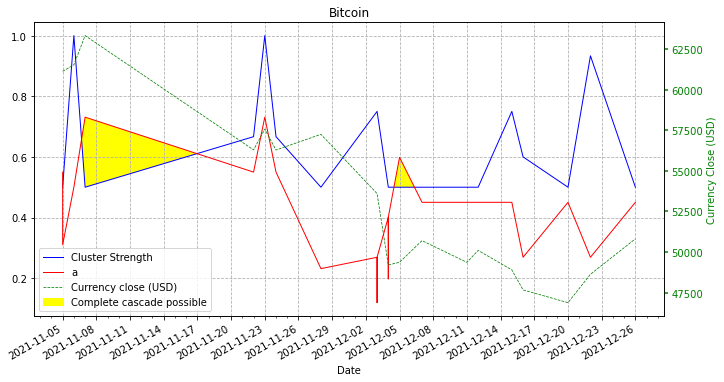

In [10]:
model_BTC = model(adj_mat=adj_mat_BTC, df_ta=df_ta_BTC, news_df=news_df_BTC, query='Bitcoin')

C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['cluster_strength'] = adj_mat['neighbours_cluster'] / adj_mat['neighbours']
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['date'] = pd.to_datetime(adj_mat['date'])
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\1559817952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

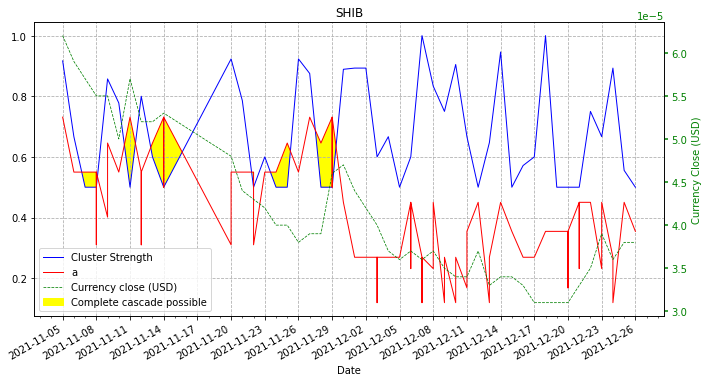

In [11]:
model_SHIB = model(adj_mat=adj_mat_SHIB, df_ta=df_ta_SHIB, news_df=news_df_SHIB, query='SHIB')

C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['cluster_strength'] = adj_mat['neighbours_cluster'] / adj_mat['neighbours']
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['date'] = pd.to_datetime(adj_mat['date'])
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\1559817952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

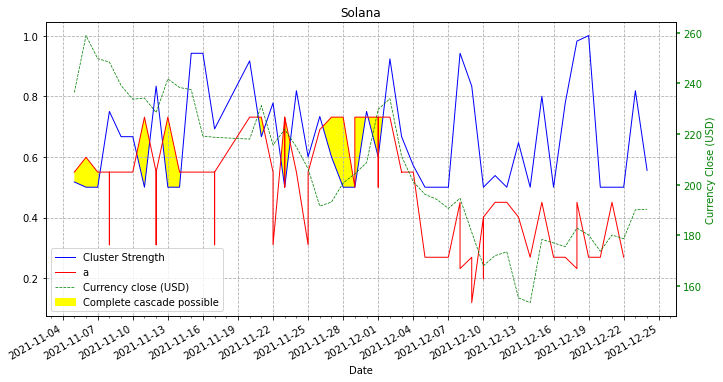

In [12]:
model_SOL = model(adj_mat=adj_mat_SOL, df_ta=df_ta_SOL, news_df=news_df_SOL, query='Solana')

C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['cluster_strength'] = adj_mat['neighbours_cluster'] / adj_mat['neighbours']
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['date'] = pd.to_datetime(adj_mat['date'])
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\1559817952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

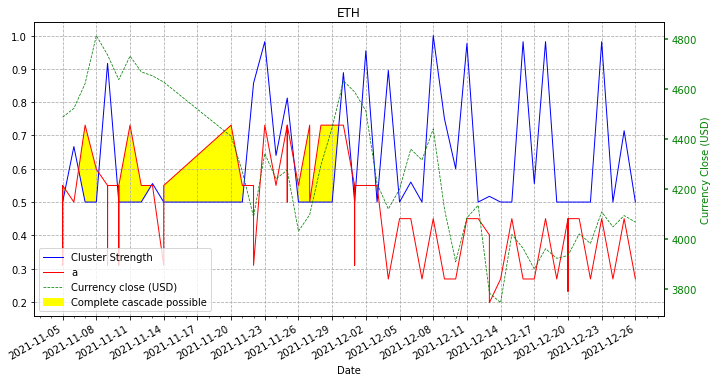

In [13]:
model_ETH = model(adj_mat=adj_mat_ETH, df_ta=df_ta_ETH, news_df=news_df_ETH, query='ETH')

C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['cluster_strength'] = adj_mat['neighbours_cluster'] / adj_mat['neighbours']
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['date'] = pd.to_datetime(adj_mat['date'])
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\1559817952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

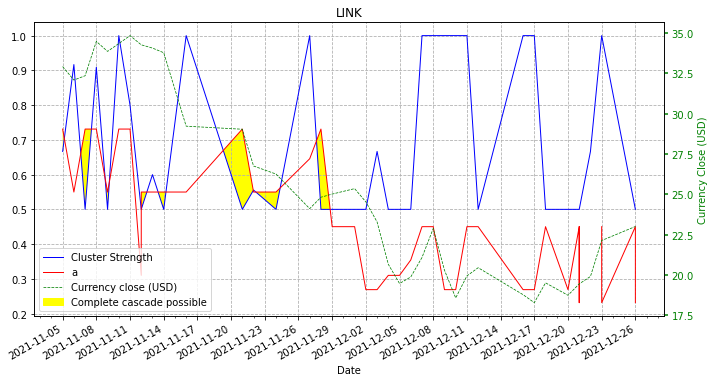

In [14]:
model_LINK = model(adj_mat=adj_mat_LINK, df_ta=df_ta_LINK, news_df=news_df_LINK, query='LINK')

C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['cluster_strength'] = adj_mat['neighbours_cluster'] / adj_mat['neighbours']
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['date'] = pd.to_datetime(adj_mat['date'])
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\1559817952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

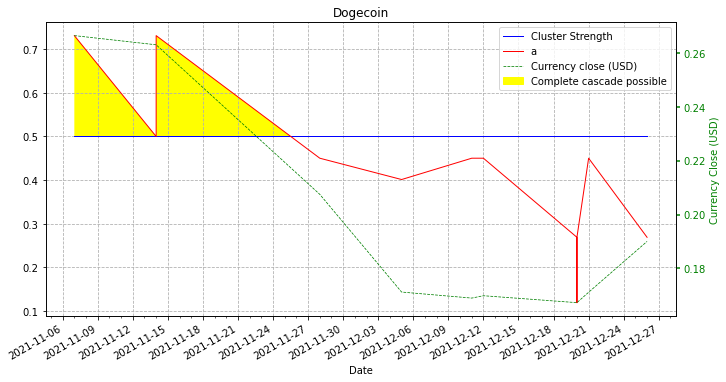

In [15]:
model_DOGE = model(adj_mat=adj_mat_DOGE, df_ta=df_ta_DOGE, news_df=news_df_DOGE, query='Dogecoin')

C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['cluster_strength'] = adj_mat['neighbours_cluster'] / adj_mat['neighbours']
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\670442587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_mat['date'] = pd.to_datetime(adj_mat['date'])
C:\Users\Christian\AppData\Local\Temp\ipykernel_8676\1559817952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

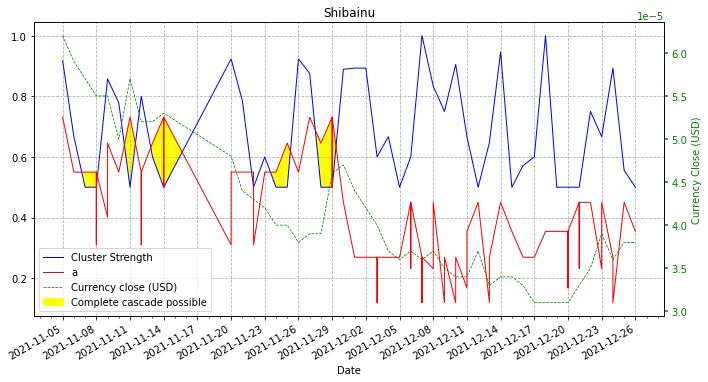

In [16]:
model_SHIB = model(adj_mat=adj_mat_SHIB, df_ta=df_ta_SHIB, news_df=news_df_SHIB, query='Shibainu')